In [1]:
import seaborn as sns
import pandas as pd
import wandb

In [2]:
# Functions

def load_sweeps(sweeps, config_save):
    filter_dict = {"sweep":{"$in":sweeps}}
    api = wandb.Api()
    entity, project = "ltecot", "quantum_optimization"
    runs = api.runs(entity + "/" + project, filters=filter_dict)
    summary_list, config_list, name_list = [], [], []
    runs_list = []
    for run in runs:
        run_data = run.history()
        remove_columns = [k for k in run_data.columns.values if k.startswith('_')]
        run_data = run_data.drop(columns=remove_columns)
        save_from_config = dict((k, run.config[k]) for k in config_save)
        save_from_config["run_name"] = run.name
        run_data = run_data.assign(**save_from_config)
        runs_list.append(run_data)
        print("Loaded " + run.name)
    runs_df = pd.concat(runs_list)
    return runs_df

In [3]:
# Load experiment runs
# Don't worry if this hangs, it can take a very long time
# Loading too many might overload your machine, so be careful when doing so

config_save = ["optimizer", "rand_seed"]

test_sweep = ["ynq6zj7a"]
test_runs = load_sweeps(test_sweep, config_save)

# ising_1d_sweeps = ["ynq6zj7a","grtaezvx","osdq0v2h","8le1ihts","v3zzxoqv","b07fcmu0","6f90a439"]
# ising_1d_runs = load_sweeps(ising_1d_sweeps, config_save)

# TODO : Add other experiments


Loaded vital-sweep-100
Loaded twilight-sweep-99
Loaded fiery-sweep-98
Loaded lilac-sweep-97
Loaded glad-sweep-96
Loaded efficient-sweep-95
Loaded fast-sweep-94
Loaded dark-sweep-93
Loaded eternal-sweep-92
Loaded chocolate-sweep-91
Loaded classic-sweep-90
Loaded legendary-sweep-89
Loaded gallant-sweep-88
Loaded atomic-sweep-87
Loaded exalted-sweep-86
Loaded noble-sweep-85
Loaded comic-sweep-84
Loaded blooming-sweep-83
Loaded frosty-sweep-82
Loaded twilight-sweep-81
Loaded rural-sweep-80
Loaded charmed-sweep-79
Loaded earthy-sweep-78
Loaded solar-sweep-77
Loaded rich-sweep-76
Loaded earthy-sweep-75
Loaded lucky-sweep-74
Loaded radiant-sweep-73
Loaded pleasant-sweep-72
Loaded comfy-sweep-71
Loaded eager-sweep-70
Loaded glad-sweep-69
Loaded lively-sweep-68
Loaded hopeful-sweep-67
Loaded swept-sweep-66
Loaded lyric-sweep-65
Loaded vital-sweep-64
Loaded legendary-sweep-63
Loaded upbeat-sweep-62
Loaded confused-sweep-61
Loaded devout-sweep-60
Loaded fallen-sweep-59
Loaded vital-sweep-58
Loade

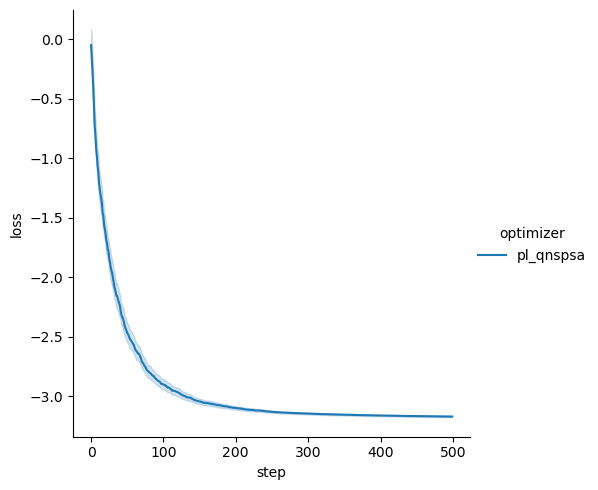

In [5]:
# print(test_runs)
sns.relplot(data=test_runs, x="step", y="loss", hue="optimizer", kind="line")